# 1. Base de dados

## 1.0 Baixando base e análise inicial

Base de poemas da Poetry Foundation.

https://www.kaggle.com/tgdivy/poetry-foundation-poems

Essa base foi escolhida com o objetivo inicial de realizar a classificação de autor, com base no texto. Inicialmente, considerou-se utilizar livros para uma classificação similar, mas para reduzir o tempo de processamento, optou-se por poemas que são mais curtos.

In [1]:
# carrega a biblioteca pandas, para fazer a leitura do corpus (base de dados)
import pandas as pd
import numpy as np
url = 'https://github.com/brusangues/pln-2021Q3-poems/blob/main/PoetryFoundationData.csv?raw=true'

corpus = pd.read_csv(url)

In [2]:
# Amostra aleatória do dataset
corpus.rename(columns={'Title':'title', 'Poem':'text', 'Poet':'poet', 'Tags':'tags'}, inplace=True)
corpus = corpus.iloc[: , 1:]
corpus.sample(5)

,title,text,poet,tags
126,\r\r\n Elephant Armageddon\...,\r\r\n\r\r\n\r\r\n\r\r\nNYTimes headline for S...,Gerard Malanga,"Living,Death,Sorrow & Grieving,Activities,Trav..."
7678,\r\r\n Effort for Distracti...,\r\r\n\r\r\n\r\r\n\r\r\nfor Henry Adams\r\r\n\...,Josephine Miles,NaN
7760,\r\r\n South Country\r\r\n ...,\r\r\nAfter the whey-faced anonymity\r\r\nOf r...,Kenneth Slessor,"Nature,Landscapes & Pastorals"
13243,\r\r\n My Madonna\r\r\n ...,"\r\r\nI haled me a woman from the street,\r\r\...",Robert W. Service,"Religion,Christianity,Arts & Sciences,Painting..."
8672,\r\r\n Branch Library\r\r\n...,"\r\r\nI wish I could find that skinny, long-be...",Edward Hirsch,"Living,Activities,Indoor Activities,School & L..."


In [3]:
corpus.shape

(13854, 4)

In [4]:
# Criando coluna com comprimento dos poemas
corpus['len'] = corpus.text.str.len()

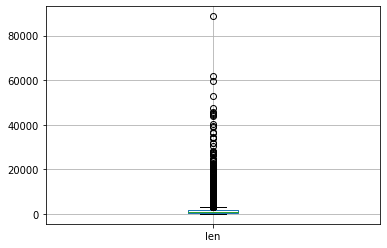

In [5]:
# Boxplot do comprimento das strings de texto
corpus.boxplot('len')

A base possui quase 14 mil poemas, cada um mapeado a um autor, e possuindo um conjunto de tags. Através do boxplot acima, percebe-se que grande maioria dos poemas tem menos de 1000 caracteres.

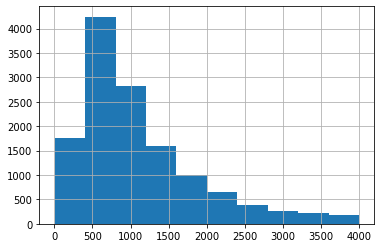

In [6]:
# Histograma do comprimento das strings
corpus[corpus.len < 4000].len.hist()

In [7]:
# Analisando os autores
corpus.poet.value_counts()

William Shakespeare      85
Alfred, Lord Tennyson    73
Emily Dickinson          51
William Wordsworth       51
Rae Armantrout           49
                         ..
Eloise Greenfield         1
David Wheatley            1
Laren McClung             1
Robert Hershon            1
Philip Good               1
Name: poet, Length: 3128, dtype: int64

In [8]:
# Analisando tags
corpus.tags.sample(20)

12503    Living,Parenthood,Religion,Social Commentaries...
9611                                 Nature,Weather,Winter
9309     Activities,Jobs & Working,Religion,Faith & Dou...
9268              Love,Infatuation & Crushes,Romantic Love
5662     Living,Life Choices,Activities,Travels & Journeys
5818     Nature,Seas, Rivers, & Streams,Weather,Arts & ...
267      Relationships,Family & Ancestors,Men & Women,M...
5159                Arts & Sciences,Language & Linguistics
3966                  Arts & Sciences,Painting & Sculpture
13647             Relationships,Pets,Arts & Sciences,Music
12926    Living,Growing Old,Infancy,Time & Brevity,Arts...
896                 Religion,Christianity,God & the Divine
10625    Living,Love,Relationships,Family & Ancestors,M...
4174                                        Nature,Animals
9818                  Arts & Sciences,Painting & Sculpture
6680        Relationships,Friends & Enemies,Nature,Animals
3201     Activities,Eating & Drinking,Social Commentari.

## 1.1 Criando labels para autores

Como a base possui muitos autores, inicialmente é feito uma seleção para utilizar apenas os autores mais frequentes como labels. Poemas de outros autores serão ignorados.

In [9]:
# Identificando poetas de maior com maior número de poemas registrados
nPoets = 5
poets = corpus.poet.value_counts()[:5]
poets

William Shakespeare      85
Alfred, Lord Tennyson    73
Emily Dickinson          51
William Wordsworth       51
Rae Armantrout           49
Name: poet, dtype: int64

In [10]:
labels = list(poets.index) + ['Other']
labels

['William Shakespeare',
 'Alfred, Lord Tennyson',
 'Emily Dickinson',
 'William Wordsworth',
 'Rae Armantrout',
 'Other']

In [11]:
# Criando coluna de label contendo os principais poetas
corpus['label'] = corpus.poet.apply(lambda x: x if x in labels else 'Other' )

In [12]:
# Criando nova coluna para índice da label
corpus['label_id'] = corpus.label.factorize()[0]


In [13]:
# Mapeamento de labels para índices
corpus_label_map = corpus.label.factorize()[1]
corpus_label_map

Index(['Other', 'William Shakespeare', 'Emily Dickinson',
       'Alfred, Lord Tennyson', 'Rae Armantrout', 'William Wordsworth'],
      dtype='object')

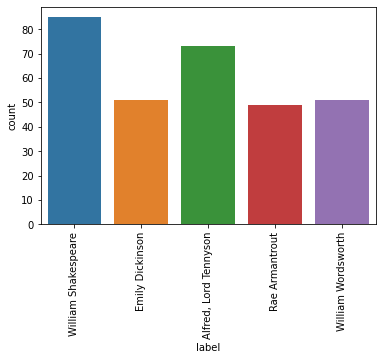

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot();
sns.countplot(x="label",data=corpus[corpus.label!='Other']);
plt.xticks(rotation=90);

## 1.2 Criando labels para tags

As tags são outra possibilidade de target para a classificação. Porém, um poema pode conter 0 ou mais tags, então trata-se de um problema de classificação multivariada.

É um problema bastante diferente da classificação por um único autor. O sklearn tem um material muito bom explicando esses diferentes tipos de classificação:  
https://scikit-learn.org/stable/modules/multiclass.html#multiclass-multioutput-classification

Para começar, é feita uma seleção das tags mais frequentes, e estas serão utilizadas para compor um vetor one-hot no qual cada posição corresponde à presença ou não da TAG.

In [15]:
# Encontrando tags mais comuns
tags = corpus.tags.values
tags[:5]

array([nan, nan, nan, nan, nan], dtype=object)

In [16]:
# Removendo nans
tags = [t for t in tags if isinstance(t,str)]
tags[:5]

['Living,Time & Brevity,Relationships,Family & Ancestors,Nature,Landscapes & Pastorals,Seas, Rivers, & Streams,Social Commentaries,History & Politics',
 'Religion,The Spiritual,Mythology & Folklore,Fairy-tales & Legends',
 'Living,Parenthood,The Body,The Mind,Nature,Trees & Flowers',
 'The Body,Family & Ancestors',
 'Infancy,Parenthood,The Body']

In [17]:
# Dividindo listas de tags
tags = [t.split(',') for t in tags]
tags = [t for sublist in tags for t in sublist]
tags[:5]

['Living', 'Time & Brevity', 'Relationships', 'Family & Ancestors', 'Nature']

In [18]:
# Value counts para determinar as tags mais comuns
nTags = 9
tags = pd.Series(tags)
print(tags.value_counts()[:nTags])
tags = tags.value_counts().index[:nTags]

Living                 6243
Social Commentaries    4302
Relationships          3856
Nature                 3613
Arts & Sciences        3039
Love                   2126
Activities             2107
Death                  1547
Religion               1483
dtype: int64


In [19]:
# # Criando coluna para marcar que há alguma tag principal
# corpus['has_tag'] = corpus.tags.apply(lambda x: sum([tag in x.split(',') for tag in tags]) if isinstance(x,str) else 0)
# # Criando colunas para as principais tags
# for tag in tags:
#     corpus['tag_'+tag] = corpus.tags.apply(lambda x: 1 if isinstance(x,str) and tag in x.split(',') else 0 )

In [20]:
# Criando funcao para vetorizar tags
def tags2vector(x):
    if isinstance(x, float):
        return np.zeros(nTags, dtype='uint8')
    x = x.split(',')
    result = []
    for tag in tags:
        if tag in x:
            result.append(1)
        else:
            result.append(0)
    result = np.array(result, dtype='uint8')
    return result

corpus['tags_vectors'] = corpus.tags.apply(tags2vector)
corpus.sample(5)['tags_vectors']

60      [0, 0, 0, 0, 0, 0, 0, 0, 0]
79      [0, 0, 0, 0, 0, 0, 0, 0, 0]
2401    [0, 0, 0, 0, 0, 0, 0, 0, 0]
3105    [1, 0, 0, 1, 0, 0, 0, 0, 0]
649     [1, 1, 0, 0, 0, 0, 0, 0, 0]
Name: tags_vectors, dtype: object

In [21]:
# Criando coluna para indicar a presença de alguma tag
corpus['tags_present'] = corpus.tags_vectors.apply(lambda x : sum(x)) > 0

## 1.3 Finalizando

In [22]:
corpus.sample(5)

,title,text,poet,tags,len,label,label_id,tags_vectors,tags_present
7879,\r\r\n [My prime of youth i...,\r\r\nMy prime of youth is but a frost of care...,Chidiock Tichborne,"Living,Death,Disappointment & Failure,Growing ...",764,Other,0,"[1, 0, 0, 0, 0, 0, 0, 1, 1]",True
9400,\r\r\n Day Room\r\r\n ...,\r\r\nHis head rose like a torch in a tomb.\r\...,Tom Sleigh,"Living,Growing Old,Arts & Sciences,Philosophy,...",2818,Other,0,"[1, 1, 0, 0, 1, 0, 0, 0, 0]",True
5884,\r\r\n Flat White Afternoon...,"\r\r\nForget about it for you’ll never win, ne...",Alan Gillis,"Living,Life Choices,The Mind,Time & Brevity,Ac...",1806,Other,0,"[1, 1, 0, 0, 0, 0, 1, 0, 0]",True
7270,\r\r\n Cor Cordium\r\r\n ...,"\r\r\nO heart of hearts, the chalice of love's...",Algernon Charles Swinburne,"Living,Death,Sorrow & Grieving,Arts & Sciences...",711,Other,0,"[1, 0, 0, 0, 1, 0, 0, 1, 0]",True
4579,\r\r\n The Only Museum\r\r\...,\r\r\nby this point you must be hungry\r\r\nfo...,Ben Purkert,"Living,The Mind,Love,Nature,Weather,Religion,G...",509,Other,0,"[1, 0, 0, 1, 1, 1, 0, 0, 1]",True


In [23]:
corpus_original = corpus.copy()

# 2. Processamento para Autores

## 2.0 Separando dataset


In [24]:
corpus = corpus_original.copy()
corpus.sample(5)

,title,text,poet,tags,len,label,label_id,tags_vectors,tags_present
5212,\r\r\n Dolphins at Seven We...,\r\r\nInward lush unpetaling purpose in pink b...,Rachel Jamison Webster,"Living,The Body,The Mind,Nature,Animals,Seas, ...",910,Other,0,"[1, 0, 0, 1, 0, 0, 0, 0, 0]",True
10261,\r\r\n Foredoom\r\r\n ...,"\r\r\nHer life was dwarfed, and wed to blight,...",Georgia Douglas Johnson,"Disappointment & Failure,Social Commentaries,G...",151,Other,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0]",True
3871,\r\r\n My Blue Shirt\r\r\n ...,\r\r\nhangs in the closet\r\r\nof this small r...,Gary Whited,NaN,829,Other,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",False
559,\r\r\n Advice from Rock Cre...,\r\r\nWhat will survive us\r\r\nhas already be...,Stephanie Burt,"Living,Time & Brevity,Nature,Animals,Social Co...",631,Other,0,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",True
10185,\r\r\n [all the time I pray...,\r\r\nAll the time I pray to Buddha I keep on ...,Kobayashi Issa,"Religion,Buddhism",69,Other,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",True


(370, 9)


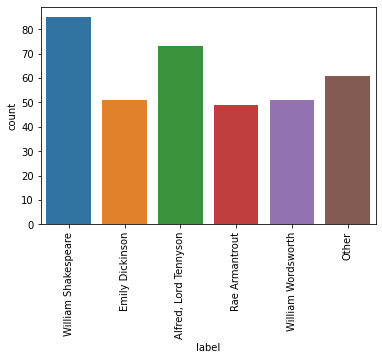

In [25]:
# Separando dataset por autores principais
corpus_labeled = corpus[corpus.label!='Other']
nSamples = len(corpus_labeled.index)//nPoets
corpus_other = corpus[corpus.label=='Other'].sample(nSamples)
corpus = pd.concat([corpus_labeled, corpus_other])

print(corpus.shape)
# contagem de textos em cada classe
plt.plot();
sns.countplot(x="label",data=corpus);
plt.xticks(rotation=90);

## 2.1. Stems e Lemmas

In [26]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [27]:
# Tokenizer sem alterações
from nltk.tokenize import wordpunct_tokenize

wordpunct_tokenize("Sample poem. Ends here.")

['Sample', 'poem', '.', 'Ends', 'here', '.']

In [28]:
# Criando tokenizador customizado
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
stm = PorterStemmer()

from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

import string

def preproc_tokenizer(text, reduc='stemmer'):
    words = wordpunct_tokenize(text) 
    # Removendo pontuação e tornando lowercase
    #words = [word.lower() for word in words]
    #words = [word for word in words if word not in string.punctuation]
    words = [word.lower() for word in words if word.isalpha()]
    # Removendo stopwords
    words = [word for word in words if word not in stopwords]
    
    if reduc.lower() == 'lemmatizer':
        words = [wnl.lemmatize(word) for word in words] 
    else:
        words = [stm.stem(word) for word in words]
    return words

In [29]:
# Funções separadas serão úteis posteriormente
def tokenizer_lemma(text):
    return preproc_tokenizer(text, reduc='lemmatizer')
def tokenizer_stem(text):
    return preproc_tokenizer(text, reduc='stemmer')

tokenizer_lemma("Sample poem. Ends here.")

['sample', 'poem', 'end']

In [30]:
# Wordclouds
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

def gen_wordcloud(texts, title, size=50):
    # conta a frequencia de cada termo 
    frequencies = Counter(token for doc in texts for token in set(doc))
    
    # gera a nuvem de palavras
    wc = WordCloud()
    wc.generate_from_frequencies(dict(frequencies.most_common(size)))
    
    # plota a nuvem
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

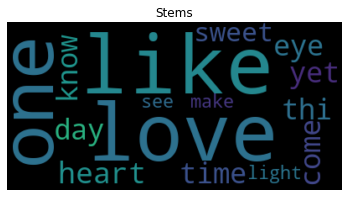

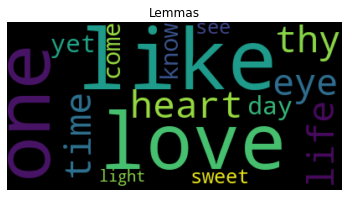

In [31]:
# Wordclouds
gen_wordcloud(corpus.text.apply(tokenizer_stem),"Stems", 15)
gen_wordcloud(corpus.text.apply(tokenizer_lemma),"Lemmas", 15)

## 2.3. Pipeline (Vectorizer + Random Forests)


**Vetorizador**  
O tfidf foi escolhido para este teste, junto com o tokenizador de lemmas.  
O número mínimo de termos por documento foi 1, pois alguns poemas são bastante
curtos, e podem utilizar um vocabulário bem variado.

In [32]:
# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer_lemma, stop_words='english', min_df=1)

**Classificador**  
O random forest foi escolhido para ser possível analisar os termos mais importantes depois.

In [33]:
# Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [34]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, classification_report

pipeline = Pipeline([
    ('vect', tfidf_vectorizer),
    ('clf', clf)
])

**Data Split**  
10% de dados para o conjunto de teste pois o conjunto de dados é muito pequeno.

In [35]:
# Data Split
from sklearn.model_selection import train_test_split

train_corpus, test_corpus =  train_test_split(corpus, test_size=0.1, random_state=0)

In [36]:
# Model training and evaluation
print( pipeline.fit(train_corpus.text.values, train_corpus.label.values) )

from sklearn import metrics

predictions = pipeline.predict(test_corpus.text)
accuracy = metrics.accuracy_score(test_corpus.label, predictions)
f1score = metrics.f1_score(test_corpus.label, predictions, average="weighted")
print("accuracy: {:0.2f}\nf1score:  {:0.2f}".format(accuracy,f1score))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<function tokenizer_lemma at 0x7f7a451830e0>)),
                ('clf', RandomForestClassifier(random_state=42))])
accuracy: 0.70
f1score:  0.70


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


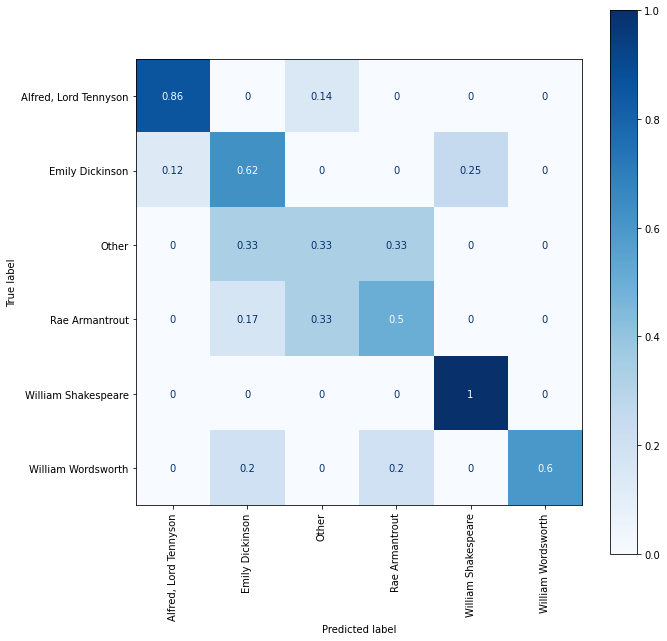

In [37]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
plt.rcParams["figure.figsize"] = (10,10)
fig = plot_confusion_matrix(pipeline, test_corpus.text, test_corpus.label,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.xticks(rotation=90);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


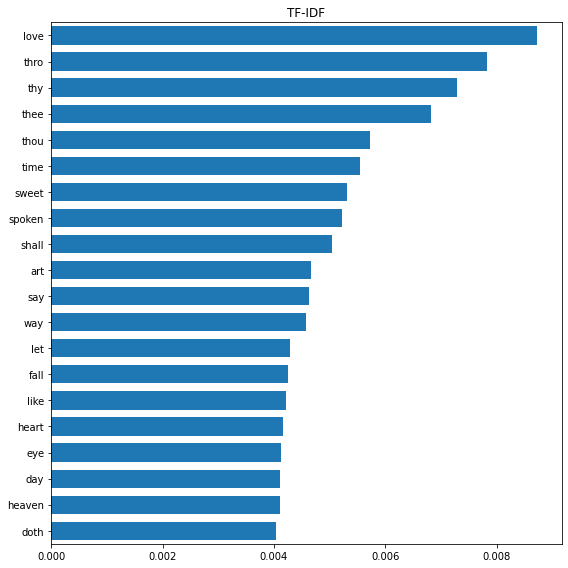

In [38]:
# Tokens mais importantes
import numpy as np

nwords = 20
counts_importance_idx = pipeline['clf'].feature_importances_.argsort()[-nwords:]

tree_indices = np.arange(0, nwords) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
ax1.barh(tree_indices,
         pipeline['clf'].feature_importances_[counts_importance_idx], height=0.7)
ax1.set_yticklabels(np.array(pipeline['vect'].get_feature_names())[counts_importance_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, nwords))
ax1.set_title("TF-IDF")

fig.tight_layout()
plt.show()

**Resultados**  
Note que em um conjunto de dados tão pequeno, um resultado apenas difícilmente é um bom indicativo da robustez do modelo.

Desse primeiro teste, pode-se perceber que é fácil classificar o autor Shakespeare pelo uso de palavras incomuns no inglês atual.  
Abaixo, uma lista de palavras utilizadas por Shakespeare:  
https://www.improvazilla.com/shakespearean-vocabulary-list

## 2.4. Testando Múltiplos Pipelines



Nesta seção, múltiplas combinações de lematizador/stemmer, tokenizador, e classificador são testadas.  
Validação cruzada é utilizada para garantir que os resultados de acurácia e f1score sejam menos enviesados pela escolha do conjunto de treino.

A validação cruzada KFOLD é um método de validação no qual o dataset é dividido em K folds.  
A cada iteração, um fold é utilizado com conjunto de teste, e os outros são utilizados como conjunto de treinamento.  
Dessa forma, o dataset inteiro será utilizado para teste pelo menos uma vez.  
Ao final, das K iterações, a média da métrica escolhida é calculada para resultad na métrica final


In [39]:
# Data Split
X = corpus.text.values
y = np.stack(corpus.label_id.values, axis=0)

# from sklearn.model_selection import train_test_split

# X_train, y_train, X_test, y_test = train_test_split(X,y, test_size=0.1, random_state=0)
# print("X_train.shape", X_train.shape)
# print("y_train.shape", y_train.shape)
# print("X_test.shape", X_test.shape)
# print("y_test.shape", y_test.shape)

In [40]:
# Vetorizadores usando lemmas e stems
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_tfidf_lemma = TfidfVectorizer(tokenizer=tokenizer_lemma, stop_words='english', min_df=1)
vectorizer_tfidf_stem  = TfidfVectorizer(tokenizer=tokenizer_stem,  stop_words='english', min_df=1)
vectorizer_count_lemma = CountVectorizer(tokenizer=tokenizer_lemma, stop_words='english', min_df=1)
vectorizer_count_stem  = CountVectorizer(tokenizer=tokenizer_stem,  stop_words='english', min_df=1)
vectorizers = {
    'tfidf_lemma': vectorizer_tfidf_lemma,
    'tfidf_stem': vectorizer_tfidf_stem,
    'count_lemma': vectorizer_count_lemma,
    'count_stem': vectorizer_count_stem}

In [41]:
# Passo intermediário para o classificador GaussianNB
#https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [42]:
# Testanto classificadores diferentes 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

classifiers = {
    'RandomForest': RandomForestClassifier(random_state=1),
    'MultinomialNB': MultinomialNB(),
    'GaussianNB': GaussianNB(),
    'LinearSVC': LinearSVC(random_state=1),
    'LogisticRegression': LogisticRegression(random_state=1),
    'MLP': MLPClassifier(random_state=1)}

In [43]:
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
import time
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
import gc
from sklearn.model_selection import KFold

In [44]:
# Utilizando KFold
folds = 10

# Definindo o número de folds, K=10
kf = KFold(n_splits=folds, random_state=1, shuffle=True) 

# Dicionário de resultados
results = defaultdict(lambda:defaultdict(list))

# Rodando Validação Cruzada
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFOLD {i+1}________________________")
    start_fold = time.time()
    # Dividindo os dados de acordo com as listas de índices geradas pelo kf.split()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gc.collect()

    for clf_name, clf in classifiers.items():
        for vect_name, vect in vectorizers.items():
            start = time.time()
            try:
                # Construindo Pipeline
                pipeline_name = clf_name+'_'+vect_name
                print(f"  pipeline: {pipeline_name.ljust(31)}",end=" | ")
                if clf_name!="GaussianNB":
                    pipeline = Pipeline([
                        ('vect', vect),
                        ('clf', clf)
                    ])
                else:
                    pipeline = Pipeline([
                        ('vect', vect),
                        ('to_dense', DenseTransformer()),
                        ('clf', clf)
                    ])

                # Treinando
                print("train",end=" | ")
                pipeline.fit(X_train, y_train)

                # Avaliando
                print("eval",end=" | ")
                y_pred = pipeline.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)
                f1score =        metrics.f1_score(y_test, y_pred, average="micro")
                #cf =     metrics.confusion_matrix(y_test, y_pred)

                # Salvando resultados
                results[pipeline_name]['accuracy'].append(accuracy)
                results[pipeline_name]['f1score'].append(f1score)
                #results[pipeline_name]['cf'] = cf

                print("accuracy: {:0.2f}".format(accuracy),end=" | ")
                print("f1score: {:0.2f}".format(f1score),end=" | ")
                
            except Exception as e:
                # Erro
                results[pipeline_name]['exception'].append(str(e))
                accuracy = f1score = cf = None
                print(f"exception: {str(e)}",end=" | ")

            # Salvando resultados
            runtime = time.time() - start
            results[pipeline_name]['runtime'] = runtime
            print("runtime: {:0.2f} s \n".format(runtime),end="")
    runtime_fold = time.time() - start_fold
    end_time = runtime_fold*(folds-(i+1))
    print("  fold runtime: {:0.2f} m \n".format(runtime_fold/60),end="")
    print("  remaining runtime: {:0.2f} m \n".format(end_time/60),end="")



FOLD 1________________________
  pipeline: RandomForest_tfidf_lemma        | train | eval | accuracy: 0.62 | f1score: 0.62 | runtime: 1.00 s 
  pipeline: RandomForest_tfidf_stem         | train | eval | accuracy: 0.68 | f1score: 0.68 | runtime: 1.96 s 
  pipeline: RandomForest_count_lemma        | train | eval | accuracy: 0.68 | f1score: 0.68 | runtime: 1.00 s 
  pipeline: RandomForest_count_stem         | train | eval | accuracy: 0.59 | f1score: 0.59 | runtime: 2.00 s 
  pipeline: MultinomialNB_tfidf_lemma       | train | eval | accuracy: 0.41 | f1score: 0.41 | runtime: 0.60 s 
  pipeline: MultinomialNB_tfidf_stem        | train | eval | accuracy: 0.41 | f1score: 0.41 | runtime: 1.64 s 
  pipeline: MultinomialNB_count_lemma       | train | eval | accuracy: 0.51 | f1score: 0.51 | runtime: 0.62 s 
  pipeline: MultinomialNB_count_stem        | train | eval | accuracy: 0.59 | f1score: 0.59 | runtime: 1.65 s 
  pipeline: GaussianNB_tfidf_lemma          | train | eval | accuracy: 0.49 | f1

## 2.5 Resultados

In [45]:
#results

In [46]:
# Lendo dicionários como dataframe
resultsDF = pd.DataFrame.from_dict(results, orient='index')
resultsDF.sample(3)

,accuracy,f1score,runtime
LinearSVC_count_stem,"[0.6756756756756757, 0.5135135135135135, 0.621...","[0.6756756756756757, 0.5135135135135135, 0.621...",1.647079
LogisticRegression_count_stem,"[0.6756756756756757, 0.5135135135135135, 0.648...","[0.6756756756756757, 0.5135135135135135, 0.648...",2.311773
RandomForest_tfidf_stem,"[0.6756756756756757, 0.4594594594594595, 0.513...","[0.6756756756756757, 0.4594594594594595, 0.513...",1.991210


In [47]:
# Calculando métricas dos folds
resultsDF['acc_mean'] = resultsDF.accuracy.apply(np.mean)
resultsDF['acc_min'] = resultsDF.accuracy.apply(np.min)
resultsDF['acc_max'] = resultsDF.accuracy.apply(np.max)
resultsDF['acc_std'] = resultsDF.accuracy.apply(np.std)

resultsDF['f1_mean'] = resultsDF.f1score.apply(np.mean)
resultsDF['f1_min'] = resultsDF.f1score.apply(np.min)
resultsDF['f1_max'] = resultsDF.f1score.apply(np.max)
resultsDF['f1_std'] = resultsDF.f1score.apply(np.std)
resultsDF.sample(3)

,accuracy,f1score,runtime,acc_mean,acc_min,acc_max,acc_std,f1_mean,f1_min,f1_max,f1_std
LogisticRegression_count_stem,"[0.6756756756756757, 0.5135135135135135, 0.648...","[0.6756756756756757, 0.5135135135135135, 0.648...",2.311773,0.656757,0.513514,0.810811,0.096733,0.656757,0.513514,0.810811,0.096733
LinearSVC_tfidf_stem,"[0.7567567567567568, 0.5675675675675675, 0.810...","[0.7567567567567567, 0.5675675675675675, 0.810...",1.629116,0.710811,0.567568,0.864865,0.083784,0.710811,0.567568,0.864865,0.083784
LogisticRegression_tfidf_stem,"[0.6486486486486487, 0.5135135135135135, 0.675...","[0.6486486486486487, 0.5135135135135135, 0.675...",1.983589,0.581081,0.459459,0.675676,0.073769,0.581081,0.459459,0.675676,0.073769


In [48]:
# Pipelines organizados por melhor acurácia
resultsDF.drop(['accuracy','f1score'],1).sort_values(by='acc_mean', ascending=False)

,runtime,acc_mean,acc_min,acc_max,acc_std,f1_mean,f1_min,f1_max,f1_std
LinearSVC_tfidf_stem,1.629116,0.710811,0.567568,0.864865,0.083784,0.710811,0.567568,0.864865,0.083784
LinearSVC_tfidf_lemma,0.637812,0.705405,0.594595,0.837838,0.079672,0.705405,0.594595,0.837838,0.079672
MLP_tfidf_stem,12.078553,0.675676,0.513514,0.810811,0.087994,0.675676,0.513514,0.810811,0.087994
MLP_count_stem,8.093532,0.664865,0.486486,0.783784,0.097597,0.664865,0.486486,0.783784,0.097597
MLP_tfidf_lemma,12.537113,0.659459,0.459459,0.783784,0.088159,0.659459,0.459459,0.783784,0.088159
LogisticRegression_count_stem,2.311773,0.656757,0.513514,0.810811,0.096733,0.656757,0.513514,0.810811,0.096733
MLP_count_lemma,7.904246,0.648649,0.432432,0.756757,0.087160,0.648649,0.432432,0.756757,0.087160
LinearSVC_count_lemma,0.630198,0.632432,0.486486,0.783784,0.086486,0.632432,0.486486,0.783784,0.086486
LogisticRegression_count_lemma,1.255824,0.632432,0.486486,0.783784,0.090611,0.632432,0.486486,0.783784,0.090611
LinearSVC_count_stem,1.647079,0.629730,0.486486,0.783784,0.097485,0.629730,0.486486,0.783784,0.097485


In [49]:
# Analisando elementos dos pipelines
lss = list(map(lambda x: x.split('_'), resultsDF.index))
resultsDF['clf'], resultsDF['vect'], resultsDF['lemma_stem'] = zip(*lss)
resultsDF.sample()

,accuracy,f1score,runtime,acc_mean,acc_min,acc_max,acc_std,f1_mean,f1_min,f1_max,f1_std,clf,vect,lemma_stem
LogisticRegression_count_stem,"[0.6756756756756757, 0.5135135135135135, 0.648...","[0.6756756756756757, 0.5135135135135135, 0.648...",2.311773,0.656757,0.513514,0.810811,0.096733,0.656757,0.513514,0.810811,0.096733,LogisticRegression,count,stem


In [50]:
# Agrupando por classificador
agg_map = {
    'acc_mean':'mean',
    'f1_mean':'mean',
    'runtime':'mean',
}
resultsDF.dropna(subset=['accuracy'])\
    .groupby(['clf']).agg(agg_map).sort_values(by='acc_mean', ascending=False)

,acc_mean,f1_mean,runtime
clf,,,
LinearSVC,0.669595,0.669595,1.136051
MLP,0.662162,0.662162,10.153361
LogisticRegression,0.608108,0.608108,1.675524
RandomForest,0.556081,0.556081,1.488144
GaussianNB,0.513514,0.513514,1.195035
MultinomialNB,0.491892,0.491892,1.115235


In [51]:
# Agrupando por vetorizador
resultsDF.dropna(subset=['accuracy'])\
    .groupby(['vect']).agg(agg_map).sort_values(by='acc_mean', ascending=False)

,acc_mean,f1_mean,runtime
vect,,,
count,0.594144,0.594144,2.456252
tfidf,0.572973,0.572973,3.131531


In [52]:
# Agrupando por lemma/stem
resultsDF.dropna(subset=['accuracy'])\
    .groupby(['lemma_stem']).agg(agg_map).sort_values(by='acc_mean', ascending=False)

,acc_mean,f1_mean,runtime
lemma_stem,,,
stem,0.589414,0.589414,3.202921
lemma,0.577703,0.577703,2.384862


In [54]:
# Salvando resultados em csv
resultsDF.to_csv('results_poets.csv', sep=';')
results_ = results.copy()
resultsDF_ = resultsDF.copy()

## 2.6 Recriando melhor pipeline e realizando testes

In [55]:
# Data Split
X = corpus.text.values
y = np.stack(corpus.label_id.values, axis=0)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=0)
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (333,)
y_train.shape (333,)
X_test.shape (37,)
y_test.shape (37,)


In [56]:
# Construindo Pipeline
pipeline = Pipeline([
    ('vect', vectorizers['tfidf_lemma']),
    ('clf', classifiers['LinearSVC'])
])
# Treinando
pipeline.fit(X_train, y_train)

# Avaliando
y_pred = pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
f1score =        metrics.f1_score(y_test, y_pred, average="micro")
cf =     metrics.confusion_matrix(y_test, y_pred)

# Imprimindo
print("accuracy: {:0.2f}".format(accuracy))
print("f1score: {:0.2f}".format(f1score))
print("cf:\n", cf)

accuracy: 0.70
f1score: 0.70
cf:
 [[3 0 0 0 0 0]
 [0 7 0 1 0 0]
 [2 0 5 1 0 0]
 [3 0 0 4 0 0]
 [3 0 1 0 2 0]
 [0 0 0 0 0 5]]


In [57]:
# Utilizando o modelo em um poema qualquer
# Selecionando poema
p = corpus.text.iloc[40]
print(corpus.iloc[40])
print("poem:\n",p[:200].__repr__())

title           \r\r\n                    Speech: Bottom's Dre...
text            \r\r\n\r\r\n\r\r\n\r\r\n(from A Midsummer Nigh...
poet                                          William Shakespeare
tags                                                          NaN
len                                                          1015
label                                         William Shakespeare
label_id                                                        1
tags_vectors                          [0, 0, 0, 0, 0, 0, 0, 0, 0]
tags_present                                                False
Name: 3075, dtype: object
poem:
 "\r\r\n\r\r\n\r\r\n\r\r\n(from A Midsummer Night's Dream, spoken by Bottom)\r\r\n\r\r\n\r\r\n\r\r\nWhen my cue comes, call me, and I will answer. My next is “Most fair Pyramus.” Heigh-ho! Peter Quince? Flute the bellows-mende"


In [58]:
# Utilizando o modelo em um poema qualquer
# Classificando
r = pipeline.predict([p])
print("prediction:", r)
label = corpus_label_map[r]
print("label:",label)

prediction: [1]
label: Index(['William Shakespeare'], dtype='object')


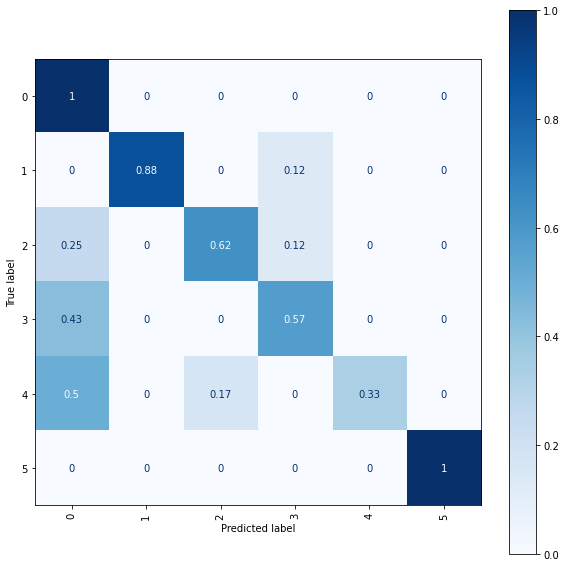

In [59]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
plt.rcParams["figure.figsize"] = (10,10)
fig = plot_confusion_matrix(pipeline, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.xticks(rotation=90);

# 3 Processamento para tags

Como há um número maior de dados tageados com as tags mais frequentes, não utilizou-se o KFOLD. 
Primeiramente, um conjunto menor, de 50% dos dados foi utilizado.  
Desse conjunto, 30% dos dados foi selecionado para treino.  

## 3.0 Separando dataset


In [60]:
# Separando dataset novamente
corpus = corpus_original

In [61]:
# Separando dataset
corpus_labeled = corpus[corpus['tags_present']]
nSamples = len(corpus_labeled.index)//nTags
corpus_other = corpus[corpus['tags_present']==False]
corpus_other = corpus_other.sample(min(nSamples, len(corpus_other.index)))
corpus = pd.concat([corpus_labeled, corpus_other])

In [62]:
corpus.shape

(13854, 9)

In [63]:
corpus.sample(3)

,title,text,poet,tags,len,label,label_id,tags_vectors,tags_present
4014,"\r\r\n Less, much less\r\r\...",\r\r\nHe hardly spoke any words\r\r\nonly two ...,Moniza Alvi,"Living,Death,The Body,Nature,Animals",1000,Other,0,"[1, 0, 0, 1, 0, 0, 0, 1, 0]",True
13052,\r\r\n Recollections of the...,\r\r\nWhen the breeze of a joyful dawn blew fr...,"Alfred, Lord Tennyson","Nature,Landscapes & Pastorals,Religion,Islam,M...",5377,"Alfred, Lord Tennyson",3,"[0, 0, 0, 1, 0, 0, 0, 0, 1]",True
8844,\r\r\n Arcade: The Search f...,\r\r\nThe Pontalba Apartments in the View-Mast...,Bin Ramke,"Living,Coming of Age,Relationships,Men & Women...",486,Other,0,"[1, 0, 1, 1, 0, 0, 0, 0, 0]",True


In [64]:
# Data Split
from sklearn.model_selection import train_test_split

# Data Split
X = corpus.text.values
y = np.stack(corpus.tags_vectors.values, axis=0)

X_, _, y_, _ = train_test_split(X,y, test_size=0.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_,y_, test_size=0.3, random_state=1)
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (6787,)
y_train.shape (6787, 9)
X_test.shape (2910,)
y_test.shape (2910, 9)


## 3.1 Múltiplos Pipelines


In [65]:
# Testanto classificadores diferentes para output multiclasse
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

classifiers = {
    'RandomForest':        RandomForestClassifier(n_estimators=100, random_state=1),
    'MRandomForest':       MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=1)),
    'MMultinomialNB':      MultiOutputClassifier(MultinomialNB()),
    'MGaussianNB':         MultiOutputClassifier(GaussianNB()),
    'MLinearSVC':          MultiOutputClassifier(LinearSVC(random_state=1)),
    'MLogisticRegression': MultiOutputClassifier(LogisticRegression(random_state=1)),
    # Não incluindo MLP pois demora muito para treinar
    #'MLP':                 MLPClassifier(random_state=1),
    #'MMLP':                MultiOutputClassifier(MLPClassifier(random_state=1))
}

Um detalhe importante sobre a classificação para múltiplas saídas utilizando o SKLEARN, é que as métricas de avaliação precisam de todas as classes verdadeiras para que um exemplo seja classificado como correto. 
___
Exemplo:  
Saída do classificador = [101]; Valor real: [001];  
esse exemplo será avaliado como errado, pois nem todas as labels foram atribuídas corretamente.
___
Isso levará a métricas com valores muito baixos. Para ter mais granularidade sobre os valores das métricas de cada classe predita, foram implementadas as funções a seguir, que realizam uma avaliação por tag.

In [66]:
# Definindo medidas de acurácia para cada tag
def accuracy_score_multioutput(y_test,y_pred):
    result = []
    for i in range(y_test.shape[1]):
        y_t = y_test[:,i]
        y_p = y_pred[:,i]
        acc = metrics.accuracy_score(y_t, y_p)
        result.append(acc)
    result = np.array(result)
    return result
def f1_score_multioutput(y_test,y_pred):
    result = []
    for i in range(y_test.shape[1]):
        y_t = y_test[:,i]
        y_p = y_pred[:,i]
        acc = metrics.f1_score(y_t, y_p)
        result.append(acc)
    result = np.array(result)
    return result

In [67]:
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
import time
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
import gc
from sklearn.model_selection import KFold

In [68]:
# Iterando 
import time
from collections import defaultdict
results = defaultdict(dict)

for clf_name, clf in classifiers.items():
    for vect_name, vect in vectorizers.items():
        start = time.time()
        try:
            # Construindo Pipeline
            pipeline_name = clf_name+'_'+vect_name
            print(f"  pipeline: {pipeline_name.ljust(31)}",end=" | ")
            if clf_name!="MGaussianNB":
                pipeline = Pipeline([
                    ('vect', vect),
                    ('clf', clf)
                ])
            else:
                pipeline = Pipeline([
                    ('vect', vect),
                    ('to_dense', DenseTransformer()),
                    ('clf', clf)
                ])

            # Treinando
            print("train",end=" | ")
            pipeline.fit(X_train, y_train)

            # Avaliando
            print("eval",end=" | ")
            y_pred = pipeline.predict(X_test)

            accuracy = metrics.accuracy_score(y_test, y_pred)
            f1score = metrics.f1_score(y_test, y_pred, average="micro")

            maccuracy = accuracy_score_multioutput(y_test, y_pred)
            mf1score = f1_score_multioutput(y_test, y_pred)

            # Salvando resultados
            results[pipeline_name]['accuracy'] = accuracy
            results[pipeline_name]['f1score'] = f1score
            results[pipeline_name]['maccuracy'] = maccuracy
            results[pipeline_name]['mf1score'] = mf1score

            print("accuracy: {:0.2f}".format(accuracy),end=" | ")
            print("f1score: {:0.2f}".format(f1score),end=" | ")
            print("maccuracy: {:0.2f}".format(np.mean(maccuracy)),end=" | ")
            print("mf1score: {:0.2f}".format(np.mean(mf1score)),end=" | ")
            
        except Exception as e:
            # Erro
            results[pipeline_name]['exception'] = str(e)
            accuracy = f1score = cf = None
            print(f"exception: {str(e)}",end=" | ")

        # Salvando resultados
        runtime = time.time() - start
        results[pipeline_name]['runtime'] = runtime
        print("runtime: {:0.2f} s \n".format(runtime),end="")

  pipeline: RandomForest_tfidf_lemma        | train | eval | accuracy: 0.09 | f1score: 0.10 | maccuracy: 0.77 | mf1score: 0.06 | runtime: 48.58 s 
  pipeline: RandomForest_tfidf_stem         | train | eval | accuracy: 0.09 | f1score: 0.11 | maccuracy: 0.78 | mf1score: 0.06 | runtime: 70.27 s 
  pipeline: RandomForest_count_lemma        | train | eval | accuracy: 0.09 | f1score: 0.12 | maccuracy: 0.77 | mf1score: 0.06 | runtime: 47.89 s 
  pipeline: RandomForest_count_stem         | train | eval | accuracy: 0.09 | f1score: 0.13 | maccuracy: 0.77 | mf1score: 0.06 | runtime: 69.60 s 
  pipeline: MRandomForest_tfidf_lemma       | train | eval | accuracy: 0.09 | f1score: 0.21 | maccuracy: 0.78 | mf1score: 0.10 | runtime: 132.01 s 
  pipeline: MRandomForest_tfidf_stem        | train | eval | accuracy: 0.10 | f1score: 0.23 | maccuracy: 0.78 | mf1score: 0.12 | runtime: 148.48 s 
  pipeline: MRandomForest_count_lemma       | train | eval | accuracy: 0.09 | f1score: 0.25 | maccuracy: 0.78 | mf1s

## 3.2 Resultados

In [69]:
# Lendo dicionários como dataframe
resultsDF = pd.DataFrame.from_dict(results, orient='index')
resultsDF.sample(3)

,accuracy,f1score,maccuracy,mf1score,runtime
MMultinomialNB_tfidf_lemma,0.087973,0.052972,"[0.5738831615120275, 0.6951890034364261, 0.706...","[0.21219822109275732, 0.002249718785151856, 0....",15.041277
RandomForest_count_lemma,0.092440,0.116945,"[0.5872852233676976, 0.7003436426116838, 0.705...","[0.34905149051490514, 0.052173913043478265, 0....",47.889495
MMultinomialNB_count_stem,0.106529,0.431652,"[0.5879725085910653, 0.7103092783505155, 0.696...","[0.6059809398619783, 0.5135603000577035, 0.357...",41.835261


In [70]:
# Calculando métricas dos scores multioutput
resultsDF['macc_mean'] = resultsDF.maccuracy.apply(np.mean)
resultsDF['macc_min'] =  resultsDF.maccuracy.apply(np.min)
resultsDF['macc_max'] =  resultsDF.maccuracy.apply(np.max)
resultsDF['macc_std'] =  resultsDF.maccuracy.apply(np.std)

resultsDF['mf1_mean'] = resultsDF.mf1score.apply(np.mean)
resultsDF['mf1_min'] =  resultsDF.mf1score.apply(np.min)
resultsDF['mf1_max'] =  resultsDF.mf1score.apply(np.max)
resultsDF['mf1_std'] =  resultsDF.mf1score.apply(np.std)
resultsDF.sample(3)

,accuracy,f1score,maccuracy,mf1score,runtime,macc_mean,macc_min,macc_max,macc_std,mf1_mean,mf1_min,mf1_max,mf1_std
MLinearSVC_tfidf_lemma,0.119244,0.430396,"[0.6054982817869415, 0.7474226804123711, 0.715...","[0.5422647527910686, 0.5180327868852458, 0.392...",16.738151,0.790493,0.605498,0.903436,0.090175,0.368829,0.163993,0.542265,0.119940
MRandomForest_tfidf_lemma,0.089003,0.207180,"[0.6065292096219931, 0.722680412371134, 0.7079...","[0.49934411893310016, 0.22627037392138066, 0.0...",132.014356,0.779076,0.606529,0.891065,0.089770,0.103564,0.000000,0.499344,0.153906
MRandomForest_tfidf_stem,0.096907,0.226272,"[0.6164948453608248, 0.7278350515463917, 0.709...","[0.5214408233276158, 0.2693726937269373, 0.040...",148.483191,0.781176,0.616495,0.891409,0.086984,0.115281,0.000000,0.521441,0.162629


In [71]:
# Pipelines organizados por melhor acurácia média
resultsDF.drop(['maccuracy','mf1score'],1).sort_values(by='macc_mean', ascending=False)

,accuracy,f1score,runtime,macc_mean,macc_min,macc_max,macc_std,mf1_mean,mf1_min,mf1_max,mf1_std
MLogisticRegression_tfidf_stem,0.125773,0.344819,49.949044,0.796716,0.637457,0.894502,0.079007,0.248962,0.017241,0.544276,0.163035
MLogisticRegression_tfidf_lemma,0.120275,0.324392,25.497506,0.794196,0.628866,0.894502,0.081006,0.227327,0.000000,0.528796,0.164244
MLinearSVC_tfidf_stem,0.129210,0.442521,43.325091,0.790951,0.612371,0.901031,0.087884,0.384261,0.206430,0.555205,0.110786
MLinearSVC_tfidf_lemma,0.119244,0.430396,16.738151,0.790493,0.605498,0.903436,0.090175,0.368829,0.163993,0.542265,0.119940
MRandomForest_tfidf_stem,0.096907,0.226272,148.483191,0.781176,0.616495,0.891409,0.086984,0.115281,0.000000,0.521441,0.162629
MRandomForest_count_stem,0.097251,0.251725,145.042750,0.780489,0.604467,0.890722,0.089388,0.144693,0.011869,0.518611,0.159839
MRandomForest_tfidf_lemma,0.089003,0.207180,132.014356,0.779076,0.606529,0.891065,0.089770,0.103564,0.000000,0.499344,0.153906
MRandomForest_count_lemma,0.086598,0.247278,133.512999,0.778236,0.594845,0.891409,0.091748,0.140475,0.005952,0.514215,0.157677
MMultinomialNB_count_stem,0.106529,0.431652,41.835261,0.777587,0.587973,0.883162,0.092140,0.304912,0.017341,0.605981,0.198582
MMultinomialNB_count_lemma,0.098969,0.421574,15.089371,0.777243,0.579038,0.885223,0.094744,0.289209,0.017341,0.605475,0.199151


In [72]:
# Analisando elementos dos pipelines
lss = list(map(lambda x: x.split('_'), resultsDF.index))
resultsDF['clf'], resultsDF['vect'], resultsDF['lemma_stem'] = zip(*lss)
resultsDF.sample()

,accuracy,f1score,maccuracy,mf1score,runtime,macc_mean,macc_min,macc_max,macc_std,mf1_mean,mf1_min,mf1_max,mf1_std,clf,vect,lemma_stem
MMultinomialNB_count_stem,0.106529,0.431652,"[0.5879725085910653, 0.7103092783505155, 0.696...","[0.6059809398619783, 0.5135603000577035, 0.357...",41.835261,0.777587,0.587973,0.883162,0.09214,0.304912,0.017341,0.605981,0.198582,MMultinomialNB,count,stem


In [73]:
# Agrupando por classificador
agg_map = {
    'accuracy':'mean',
    'f1score':'mean',
    'runtime':'mean',
    'macc_mean':'mean',
    'mf1_mean':'mean',
}
resultsDF.dropna(subset=['accuracy'])\
    .groupby(['clf']).agg(agg_map).sort_values(by='macc_mean', ascending=False)

,accuracy,f1score,runtime,macc_mean,mf1_mean
clf,,,,,
MLogisticRegression,0.115378,0.388671,42.767928,0.784927,0.319553
MRandomForest,0.092440,0.233114,139.763324,0.779744,0.126003
RandomForest,0.090034,0.115117,59.083736,0.774504,0.059869
MMultinomialNB,0.096134,0.239905,28.417118,0.774198,0.160571
MLinearSVC,0.101460,0.435191,35.643198,0.769931,0.386881
MGaussianNB,0.036168,0.331230,97.357357,0.654649,0.266501


In [74]:
# Agrupando por vetorizador
resultsDF.dropna(subset=['accuracy'])\
    .groupby(['vect']).agg(agg_map).sort_values(by='macc_mean', ascending=False)

,accuracy,f1score,runtime,macc_mean,mf1_mean
vect,,,,,
tfidf,0.092812,0.245747,65.262816,0.761690,0.178300
count,0.084393,0.335330,69.081404,0.750961,0.261493


In [75]:
# Agrupando por lemma/stem
resultsDF.dropna(subset=['accuracy'])\
    .groupby(['lemma_stem']).agg(agg_map).sort_values(by='macc_mean', ascending=False)

,accuracy,f1score,runtime,macc_mean,mf1_mean
lemma_stem,,,,,
lemma,0.086942,0.285353,57.763363,0.758976,0.214699
stem,0.090263,0.295723,76.580858,0.753675,0.225094


In [76]:
resultsDF.to_csv('results_tags.csv', sep=';')

## 3.3 Recriando melhor pipeline e realizando testes

In [77]:
# Construindo Pipeline
pipeline = Pipeline([
    ('vect', vectorizers['tfidf_lemma']),
    ('clf', classifiers['MLogisticRegression'])
])
# Treinando
pipeline.fit(X_train, y_train)

# Avaliando
y_pred = pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
f1score = metrics.f1_score(y_test, y_pred, average="micro")
maccuracy = accuracy_score_multioutput(y_test, y_pred)
mf1score = f1_score_multioutput(y_test, y_pred)

# Imprimindo
print("accuracy: {:0.2f}".format(accuracy))
print("f1score: {:0.2f}".format(f1score))
print("maccuracy_mean: {:0.2f}".format(np.mean(maccuracy)))
print("mf1score_mean: {:0.2f}".format( np.mean(mf1score)))
print("maccuracy:\n", maccuracy)
print("mf1score:\n", mf1score)

accuracy: 0.12
f1score: 0.32
maccuracy_mean: 0.79
mf1score_mean: 0.23
maccuracy:
 [0.62886598 0.74914089 0.72852234 0.77628866 0.78487973 0.85429553
 0.84226804 0.88900344 0.89450172]
mf1score:
 [0.52879581 0.39368771 0.2254902  0.38293839 0.14246575 0.19391635
 0.         0.05830904 0.12034384]


In [78]:
# Utilizando o modelo em um poema qualquer
# Selecionando poema
p = corpus.text.iloc[40]
print(corpus.iloc[40])
print("poem:\n",p[:200].__repr__())

title           \r\r\n                    At the Other End of ...
text            \r\r\nWhen he called, there were 261 emotions\...
poet                                                   Sandra Lim
tags                    Living,The Mind,Relationships,Men & Women
len                                                           611
label                                                       Other
label_id                                                        0
tags_vectors                          [1, 0, 1, 0, 0, 0, 0, 0, 0]
tags_present                                                 True
Name: 221, dtype: object
poem:
 '\r\r\nWhen he called, there were 261 emotions\r\r\nat play. I thought there were only wistfulness,\r\r\nhumiliation, and mere bitterness left, but lo,\r\r\nI see now the brilliance in the numbers. \r\r\nEmotions 75 '


In [79]:
# Utilizando o modelo em um poema qualquer
# Classificando
r = pipeline.predict([p])[0]
print("prediction:", r)
label = [tags[i] for i,value in enumerate(r) if value==True]
label = ",".join(label)
print("label:",label)

prediction: [1 0 0 0 0 0 0 0 0]
label: Living
